# SINDy-PI Feature Overview

This notebook provides a simple overview of the basic functionality of SINDy-PI implemented in PySINDy. This is based off of the paper "Kaheman, K., Kutz, J. N., & Brunton, S. L. (2020). SINDy-PI: a robust algorithm for parallel implicit sparse identification of nonlinear dynamics. Proceedings of the Royal Society A, 476(2242), 20200279."

In [1]:
# Import libraries.
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pysindy as ps 
from pysindy.differentiation import FiniteDifference
import scipy.integrate as integrate 
import matplotlib.gridspec as gridspec
import numexpr as ne
from numpy import cos, sin
from pysindy.utils import enzyme

# Example to show library functionality
Below, we define custom libraries for x and x_dot, showing that the resulting full library and library names are a tensor product of the two independent libraries. Note that lambda x: '', is used to trick the code to generate the constant function 1 without generating repeated entries.

In [2]:
t = np.linspace(0, 1, 5)
x = np.ones((5, 2))
functions = [lambda x: 1, lambda x : np.exp(x), lambda x,y : np.sin(x+y)]
x_dot_functions = [lambda x: 1, lambda x : x]
function_names = [lambda x: '',
                  lambda x : 'exp(' + x + ')',
                  lambda x, y : 'sin(' + x + y + ')',
                  lambda x: '',
                  lambda x : x]
lib = ps.SINDyPILibrary(library_functions=functions,
                        x_dot_library_functions=x_dot_functions,
                        function_names=function_names, t=t
                        ).fit(x)
print(lib.transform(x))
print(lib.get_feature_names())

[[ 1.00000000e+00  2.71828183e+00  2.71828183e+00  9.09297427e-01
   2.22044605e-16  6.03579815e-16  6.03579815e-16  2.01904588e-16
   2.22044605e-16  6.03579815e-16  6.03579815e-16  2.01904588e-16]
 [ 1.00000000e+00  2.71828183e+00  2.71828183e+00  9.09297427e-01
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00  2.71828183e+00  2.71828183e+00  9.09297427e-01
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00  2.71828183e+00  2.71828183e+00  9.09297427e-01
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00  2.71828183e+00  2.71828183e+00  9.09297427e-01
  -2.22044605e-16 -6.03579815e-16 -6.03579815e-16 -2.01904588e-16
  -2.22044605e-16 -6.03579815e-16 -6.03579815e-16 -2.01904588e-16]]
['',

# Julia language is required for SINDy-PI to be able to solve differential algebraic equations (DAEs)

Note that on my computer, at a terminal, I need to do: <br>
julia  (enters the julia console) <br>
import Pkg <br>
Pkg.add("PyCall") <br>
Pkg.add("DiffEqBase") <br>
Pkg.add("DifferentialEquations") <br>
exit() <br>
jupyter notebook <br>

In [3]:
from julia.api import Julia
jl = Julia(compiled_modules=False)
from diffeqpy import de

# Define some functions that facilitate integration
SINDy-PI produces differential algebraic equations (DAEs), which cannot be generally solved by python's native routines odeint or solve_ivp. Instead, we need to define some functions to put the equations into a format amenable to the Julia-reliant diffeqpy package.

In [4]:
# Fix feature names
def fix_feature_names(feature_names, r):
    for i in range(len(feature_names)):
        if feature_names[i] == '':
            feature_names[i] = '1'
        for j in range(r):
            feature_names[i] = feature_names[i].replace("sin(x" + str(j) + ")", "sin(u[" + str(j) + "])*")  
            feature_names[i] = feature_names[i].replace("cos(x" + str(j) + ")", "cos(u[" + str(j) + "])*")
        for j in range(r):
            feature_names[i] = feature_names[i].replace("x_dot" + str(j), "du[" + str(j) + "]*")  
            feature_names[i] = feature_names[i].replace("x" + str(j), "u[" + str(j) + "]*") 
        if feature_names[i][-1] == '*':
            feature_names[i] = feature_names[i][:-1]
        print(i, feature_names[i])
    return feature_names


# Function to build a symbolic DAE
# Extract the coefficients and build up a string to evaluate
def build_symbolic_DAE(sindy_opt, feature_names, r, coefs, coef_indices):
    full_string = ''
    for k in range(r):
        eval_string = ''
        for i in range(len(feature_names)):
            eval_string += 'coefs[' + str(i) + ', ' + str(k) + '] * eval(feature_names[' + str(i) + '])'
            if i != len(feature_names) - 1:
                eval_string += ' + '
            else:
                eval_string += ' - eval(feature_names[' + str(coef_indices[k]) + '])' # du[' + str(k) + ']'
        # Okay, now have the eval string for one of the ODEs and need to string together
        if k == 0 and r == 1:
            full_string = eval_string
        elif k == 0:
            full_string += '[' + eval_string + ', '
        elif k != 0 and k != r - 1:
            full_string += eval_string + ', '
        elif k != 0 and k == r - 1:
            full_string += eval_string + ']'
    return full_string

In [5]:
# define parameters
r = 1
dt = 0.01
T = 5
t = np.arange(0, T + dt, dt)
x0_train = [0.55]
x_train = integrate.odeint(enzyme, x0_train, t)
x0_test = [0.05]
x_test = integrate.odeint(enzyme, x0_test, t)

fd = FiniteDifference(drop_endpoints=False)
x_dot_train = np.nan_to_num(fd._differentiate(x_train, t))
x_dot_test = np.nan_to_num(fd._differentiate(x_test, t))

# Initialize custom SINDy library so that we can have x_dot inside it. Using the library
# Found in Equation A1 in the SINDy-PI paper
x_library_functions = [lambda x:1, lambda x:x, lambda x, y:x * y, lambda x:x ** 2, 
                       lambda x, y, z:x * y * z, lambda x, y: x * y ** 2, lambda x: x ** 3,
                       lambda x, y, z, w: x * y * z * w, lambda x, y, z:x * y * z ** 2,
                       lambda x, y:x * y ** 3, lambda x:x ** 4]
x_dot_library_functions = [lambda x:1, lambda x:x]
        
library_function_names = [lambda x:'', lambda x:x, lambda x, y: x + y, lambda x:x + x, 
                          lambda x, y, z:x + y + z, lambda x, y: x + y + y, lambda x: x + x + x,
                          lambda x, y, z, w: x + y + z + w, lambda x, y, z:x + y + z + z,
                          lambda x, y:x + y + y + y, lambda x:x + x + x + x,
                          lambda x:'', lambda x:x] 
sindy_library = ps.SINDyPILibrary(library_functions=x_library_functions, 
                                  x_dot_library_functions=x_dot_library_functions,
                                  t=t[1:-1],
                                  function_names=library_function_names,
                                  )

sindy_opt = ps.SINDyPI(threshold=1e-7, tol=1e-10, thresholder="l1", max_iter=20000)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_train, t=t)
model.print()

Solver failed on model  3 , setting coefs to zeros
 = 5.000 x0 + 0.001 x0x0x0 + 1.666 x_dot0 + 5.557 x0x_dot0
x0 = 0.200  + -0.333 x_dot0 + -1.111 x0x_dot0
x0x0 = 0.198 x0 + 0.006 x0x0x0 + -0.338 x0x_dot0 + -1.099 x0x0x_dot0
x0x0x0 = 0.000
x0x0x0x0 = -0.001  + 0.362 x0x0x0 + 0.041 x0x_dot0 + -1.206 x0x0x0x0x_dot0
x_dot0 = 0.600  + -3.000 x0 + -3.334 x0x_dot0
x0x_dot0 = 0.180  + -0.899 x0 + -0.300 x_dot0
x0x0x_dot0 = -0.001  + 0.177 x0 + -0.848 x0x0 + -0.030 x0x0x0 + -0.262 x0x_dot0
x0x0x0x_dot0 = 0.003  + 0.001 x0 + -0.389 x0x0x0 + -0.249 x0x0x0x0 + -0.107 x0x_dot0
x0x0x0x0x_dot0 = 0.001  + -0.669 x0x0x0x0 + -0.005 x_dot0 + 0.028 x0x_dot0 + -0.268 x0x0x_dot0


0 1
1 u[0]
2 u[0]*u[0]
3 u[0]*u[0]*u[0]
4 u[0]*u[0]*u[0]*u[0]
5 du[0]
6 u[0]*du[0]
7 u[0]*u[0]*du[0]
8 u[0]*u[0]*u[0]*du[0]
9 u[0]*u[0]*u[0]*u[0]*du[0]


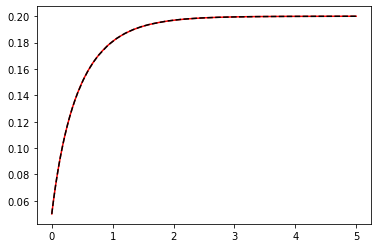

In [6]:
# Need to decide what subset of the SINDy-PI equations to evolve as
# the coupled system of ODEs
coef_indices = np.arange(1, r + 1)
coefs = np.transpose(sindy_opt.coef_)[:, coef_indices]
feature_names = model.get_feature_names()
feature_names = fix_feature_names(feature_names, r)
eval_string = build_symbolic_DAE(sindy_opt, feature_names, 1, coefs, coef_indices)

# Define a SINDy differential algebraic equation (DAE)
def SINDy_model(du, u, p, t):
    resid = eval(eval_string)
    return resid

du0 = [-0.04]
tspan = (t[0], t[-1])
differential_vars = [True]
prob = de.DAEProblem(SINDy_model, du0, x0_test, tspan, differential_vars=differential_vars)
plt.plot(t, x_test, 'r')
sol = de.solve(prob)
plt.plot(sol.t, sol.u, 'k--')

0 1
1 u[0]
2 u[0]*u[0]
3 u[0]*u[0]*u[0]
4 u[0]*u[0]*u[0]*u[0]
5 du[0]
6 u[0]*du[0]
7 u[0]*u[0]*du[0]
8 u[0]*u[0]*u[0]*du[0]
9 u[0]*u[0]*u[0]*u[0]*du[0]
 = 5.000 x0 + 0.001 x0x0x0 + 1.666 x_dot0 + 5.557 x0x_dot0
x0 = 0.200  + -0.333 x_dot0 + -1.111 x0x_dot0
x0x0 = 0.198 x0 + 0.006 x0x0x0 + -0.338 x0x_dot0 + -1.099 x0x0x_dot0
x0x0x0 = 0.000
x0x0x0x0 = -0.001  + 0.362 x0x0x0 + 0.041 x0x_dot0 + -1.206 x0x0x0x0x_dot0
x_dot0 = 0.600  + -3.000 x0 + -3.334 x0x_dot0
x0x_dot0 = 0.180  + -0.899 x0 + -0.300 x_dot0
x0x0x_dot0 = -0.001  + 0.177 x0 + -0.848 x0x0 + -0.030 x0x0x0 + -0.262 x0x_dot0
x0x0x0x_dot0 = 0.003  + 0.001 x0 + -0.389 x0x0x0 + -0.249 x0x0x0x0 + -0.107 x0x_dot0
x0x0x0x0x_dot0 = 0.001  + -0.669 x0x0x0x0 + -0.005 x_dot0 + 0.028 x0x_dot0 + -0.268 x0x0x_dot0


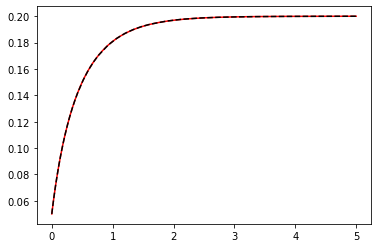

In [7]:
# Repeat our success with a different DAE from SINDy-PI
coef_indices = np.arange(5, r + 5)
coefs = np.transpose(sindy_opt.coef_)[:, coef_indices]
feature_names = model.get_feature_names()
feature_names = fix_feature_names(feature_names, r)
eval_string = build_symbolic_DAE(sindy_opt, feature_names, 1, coefs, coef_indices)
model.print()

prob = de.DAEProblem(SINDy_model, du0, x0_test, tspan, differential_vars=differential_vars)
plt.plot(t, x_test, 'r')
sol = de.solve(prob)
plt.plot(sol.t, sol.u, 'k--')